<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left"></td>
<h2 style="white-space: nowrap">Image Processing Laboratory Notebooks</h2>
<hr style="clear:both">
<p style="font-size:0.85em; margin:2px; text-align:justify">
This Juypter notebook is part of a series of computer laboratories which are designed
to teach image-processing programming; they are running on the EPFL's Noto server. They are the practical complement of the theoretical lectures of the EPFL's Master course <b>Image Processing II</b> 
(<a href="https://moodle.epfl.ch/course/view.php?id=463">MICRO-512</a>) taught by Dr. D. Sage, Dr. M. Liebling, Prof. M. Unser and Prof. D. Van de Ville.
</p>
<p style="font-size:0.85em; margin:2px; text-align:justify">
The project is funded by the Center for Digital Education and the School of Engineering. It is owned by the <a href="http://bigwww.epfl.ch/">Biomedical Imaging Group</a>. 
The distribution or the reproduction of the notebook is strictly prohibited without the written consent of the authors.  &copy; EPFL 2022.
</p>
<p style="font-size:0.85em; margin:0px"><b>Authors</b>: 
    <a href="mailto:pol.delaguilapla@epfl.ch">Pol del Aguila Pla</a>, 
    <a href="mailto:kay.lachler@epfl.ch">Kay Lächler</a>,
    <a href="mailto:alejandro.nogueronaramburu@epfl.ch">Alejandro Noguerón Arámburu</a>,
    <a href="mailto:daniel.sage@epfl.ch">Daniel Sage</a>, and
    <a href="mailto:kamil.seghrouchni@epfl.ch">Kamil Seghrouchni</a>.
     
</p>
<hr style="clear:both">
<h1>Lab 4.1: Orientation warm-up</h1>
<div style="background-color:#F0F0F0;padding:4px">
    <p style="margin:4px;"><b>Released</b>: Thursday March 3, 2022</p>
    <p style="margin:4px;"><b>Submission</b>: <span style="color:red">Friday March 11, 2022</span> (before 11:59PM) on <a href="https://moodle.epfl.ch/course/view.php?id=463">Moodle</a></p>
    <p style="margin:4px;"><b>Grade weigth</b>: Lab 4 (18 points), 7.5 % of the overall grade</p>
    <p style="margin:4px;"><b>Remote help</b>: Monday 7 March, 2022 on Zoom (12h-13h, see Moodle for link) and Thursday 10 March on campus</p>    
    <p style="margin:4px;"><b>Related lectures</b>: Chapter 6</p>
</div>

### Student Name: Cornelius van den Heuvel
### SCIPER: 311699

Double-click on this cell and fill your name and SCIPER number. Then, run the cell below to verify your identity in Noto and set the seed for random results.

In [1]:
import getpass
# This line recovers your camipro number to mark the images with your ID
uid = int(getpass.getuser().split('-')[2]) if len(getpass.getuser().split('-')) > 2 else ord(getpass.getuser()[0])
print(f'SCIPER: {uid}')

SCIPER: 311699


## <a name="imports_"></a> Imports
In the next cell we import Python libraries we will use throughout the lab, as well as the `ImageViewer` class, created specifically for this course, which provides interactive image visualization based on the `ipywidgets` library. We will import:

* [`matplotlib.pyplot`](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.html), to display images,
* [`ipywidgets`](https://ipywidgets.readthedocs.io/en/latest/), to make the image display interactive,
* [`numpy`](https://numpy.org/doc/stable/reference/index.html), for mathematical operations on arrays,
* [`cv2`](https://docs.opencv.org/2.4/index.html), for image processing tasks.

We will then load the `ImageViewer` class (see the documentation [here](https://github.com/Biomedical-Imaging-Group/interactive-kit/wiki/Image-Viewer) or run the Python command `help(viewer)` after loading the class).

Finally, we load the images you will use in the exercise to test your functions. 

In [2]:
# Configure plotting as dynamic
%matplotlib widget

# Import standard required packages for this exercise
import warnings
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import cv2 as cv 
import skimage
from skimage import feature
from interactive_kit import imviewer as viewer 

# Load images to be used in this exercise 
corner = cv.imread('images/corner.tif', cv.IMREAD_UNCHANGED)
dendrochronology = cv.imread('images/dendrochronolgy.tif', cv.IMREAD_UNCHANGED)
fingerprint = cv.imread('images/fingerprint.tif', cv.IMREAD_UNCHANGED)
harris_corner = cv.imread('images/harris-corner.tif', cv.IMREAD_UNCHANGED)
wave_ramp = cv.imread('images/wave-ramp.tif', cv.IMREAD_UNCHANGED)

# Orientation laboratory (13 points)

In this lab we will implement the computation of the structure tensor presented in Chapter 6.2, which can be used to perform directional image analysis.

The block-diagram of the complete system is shown in the following flowchart, where $f(x,y)$ is the graylevel input image.

<img src="images/block-diagram.png" alt="Drawing" style="width: 800px;"/>

Successively, you will implement the functions
* `structure_tensor` to generate the structure tensor matrix,
* `orientation_features`, which implements the whole chain of calculations to generate the features needed for directional analysis, and
* `colorize_features` to display the calculated features as a color image.


Once you ensured that the functions are correct, you will use them in two applications that rely on directional image analysis, 
* a method to select specific orientations, and
* a keypoint detector (Harris corner detector). 

Finally, we will analyze the `structure_tensor` function a bit more closely and see if we can improve the obtained results.

<div class = 'alert alert-info'>

<b>Note:</b> This part of the lab will be carried out completely in Python.
</div>

## <a id="ToC_2_Orientation"></a>Table of contents
1. [Structure tensor matrix](#1.-Structure-tensor-matrix-(2-points)) **(2 points)**
2. [Orientation features](#2.-Orientation-features)
    1. [Feature calculation](#2.A.-Feature-calculation-(4-points)) **(4 points)**
    2. [Feature visualization](#2.B.-Feature-visualization-(2-points)) **(2 points)**
3. [Application](#3.-Application)
    1. [Selection of specific orientations](#3.A.-Selection-of-specific-orientations-(2-points)) **(2 points)**
    2. [Harris corner detector](#3.B.-Harris-corner-detector-(2-points)) **(2 points)**
    3. [*Advanced:* Isotropic filtering in the Fourier space](#3.C.-Advanced:-Isotropic-filtering-in-the-Fourier-space-(1-point)) **(1 point)**

### Visualize images
First of all, run the cell below to get familiar with the images we will be using. Remember you can use `Next` and `Prev` to cycle through the images.

In [3]:
# Declare image_list for ImageViewer
img_list = [corner, dendrochronology, fingerprint, harris_corner, wave_ramp]
imgs_viewer = viewer(img_list, widgets=True)

# 1. Structure tensor matrix (2 points)
[Back to table of contents](#ToC_2_Orientation)

To calculate the elements $J_{xx}$, $J_{xy}$ and $J_{yy}$ of the structure tensor, we only need two computational blocks: a Gaussian filter and a gradient filter. For the gradient, we will use the **OpenCV Sobel filter** [`cv.Sobel(src, ddepth, dx, dy, ksize)`](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d). Click on the link to see its documentation and choose the right input parameters to apply a **first-order** Sobel filter of **size $3\times3$**. 

For the smoothing filter we will use the standard Gaussian filter provided by OpenCV [`cv.GaussianBlur(src, ksize, sigmaX)`](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1) with default boundary conditions (`BORDER_DEFAULT` or `BORDER_REFLECT_101`). If you are unsure about its input parameters, go check the documentation.

**For 2 points**, complete the function `structure_tensor` in the cell below. It may be useful to revisit the [figure](#Orientation-laboratory-(13-points)) at the start of this notebook before starting.

<div class="alert alert-info">

<b>Hints:</b> 
<ul><li>Take a moment to go thoroughly through the documentation! It will make your life much easier.     
</li><li><b><code>cv.Sobel</code>:</b> set <code>ddepth=cv.CV_64F</code> since the gradient can be a negative floating point number.
</li><li><b><code>cv.GaussianBlur</code>:</b> set <code>ksize=(0,0)</code> to let the function choose the filter size automatically from <code>sigmaX</code>.
</li><li><b>Multiplication:</b> Note that, contrary to Matlab and other languages, the Python operator <code>*</code> applied to a NumPy Array performs <i>element-wise</i> multiplication.
</li><li><b>Exponent:</b> Note that Python's exponent operator is <code>**</code>.
</li><li>To ensure that you define the right parameter in a function call always specify the name of the parameter. For example: <code>cv.Sobel(src=img, ddepth=cv.CV_64F, dx=1, dy=1, ksize=5)</code> is much easier to understand and debug than <code>cv.Sobel(img, cv.CV_64F, 1, 1, 5)</code>.</ul>
</div>

In [4]:
# Function that calculates the elements Jxx, Jxy and Jyy of the structure tensor matrix
def structure_tensor(img, sigma):
    # Initialize output vatiables
    Jxx = np.zeros(img.shape)
    Jxy = np.zeros(img.shape)
    Jyy = np.zeros(img.shape)
    
    # YOUR CODE HERE
    
    # Calculate the first order derivatives w.r.t x and y
    fx = cv.Sobel(src=img, ddepth=cv.CV_64F, dx=1, dy=0, ksize=3)
    fy = cv.Sobel(src=img, ddepth=cv.CV_64F, dx=0, dy=1, ksize=3)

    # The elements of the structure tensor are Gaussian blurred
    # squared derivatives. (Note: by default, sigmaY has the same value as sigmaX)
    Jxx = cv.GaussianBlur(src=fx**2, ksize=(0,0), sigmaX=sigma)
    Jxy = cv.GaussianBlur(src=fx*fy, ksize=(0,0), sigmaX=sigma)
    Jyy = cv.GaussianBlur(src=fy**2, ksize=(0,0), sigmaX=sigma)
    
    return Jxx, Jxy, Jyy

Let's perform a quick sanity check on a simple $11 \times 11$ **impulse image** using `sigma=1`. 
<div class="alert alert-info">

**Note:** You can modify the input image and the sigma value in the cell below to observe the different results.
</div>

In [5]:
# Define impulse image
size = 11
test_img = np.zeros((size,size))
test_img[size//2, size//2] = 1
# Run function and display the result
Jxx, Jxy, Jyy = structure_tensor(test_img, sigma = 1)
plt.close('all')
view = viewer([test_img, Jxx, Jyy, Jxy], subplots=(2,2))

Button(description='Show Widgets', style=ButtonStyle())

Specifically, we will first check that $J_{xx}$ and $J_{yy}$ are non-negative and identical to each other when rotated by $90^{\circ}$, which should be the case for this impulse image. Then, we will also check that $J_{xy}$ contains both negative and non-negative numbers, and that all elements that are either in the fifth row or the fifth column of $J_{xy}$ are zero. 

Because the structure tensor is a crucial part of this lab, we will also perform more sophisticated sanity checks comparing your results to our pre-computed correct results.

In [6]:
# Basic sanity checks
# Re-run example in case you've played around with the previous cell
test_img = np.zeros((11,11)); test_img[5, 5] = 1
Jxx, Jxy, Jyy = structure_tensor(test_img, sigma = 1)

# No negative values in Jxx and Jyy
if not (np.all(Jxx >= 0) and np.all(Jyy >= 0)):
    print('WARNING!\nJxx and Jyy should not contain any negative values.\n')
if not np.allclose(np.rot90(Jxx), Jyy):
    print('WARNING!\nJxx should be the same as Jyy but rotated 90 degrees.\n')

# Jxy both positive and negative
if not (np.any(Jxy > 0) and np.any(Jxy < 0)):
    print('WARNING!\nJxy should contain both negative and positive values.\n')

# Fifth row/col zeros
if not (np.all(abs(Jxy[5, :]) < 1e-5) and np.all(abs(Jxy[:, 5]) < 1e-5)):
    print('WARNING!\nThe fifth row/column of Jxy should only have zeros.\n')

# Comparison to pre-computed correct results
# Boundaries should be close to zero
error_check = [False, False, False]
mask = np.ones(test_img.shape, dtype=bool); mask[2:9, 2:9] = False
if not np.all(np.abs(Jxx[mask]) < 0.01):
    print('WARNING!\nJxx is not yet correct, values outside the range x=[2,8], y=[2,8] should be close to 0.\n')
    error_check[0] = True
if not np.all(np.abs(Jyy[mask]) < 0.01):
    print('WARNING!\nJyy is not yet correct, values outside the range x=[2,8], y=[2,8] should be close to 0.\n')
    error_check[1] = True
if not np.all(np.abs(Jxy[mask]) < 0.01):
    print('WARNING!\nJxy is not yet correct, values outside the range x=[2,8], y=[2,8] should be close to 0.\n')
    error_check[2] = True
# Correct outputs
Jxx_corr = np.array([[0.004, 0.018, 0.033, 0.035, 0.033, 0.018, 0.004],
                     [0.025, 0.114, 0.209, 0.224, 0.209, 0.114, 0.025],
                     [0.077, 0.35,  0.644, 0.688, 0.644, 0.35,  0.077],
                     [0.113, 0.512, 0.942, 1.006, 0.942, 0.512, 0.113],
                     [0.077, 0.35,  0.644, 0.688, 0.644, 0.35,  0.077],
                     [0.025, 0.114, 0.209, 0.224, 0.209, 0.114, 0.025],
                     [0.004, 0.018, 0.033, 0.035, 0.033, 0.018, 0.004]])
Jyy_corr = Jxx_corr.T
Jxy_corr = np.array([[ 0.003,  0.013,  0.019,  0.   , -0.019, -0.013, -0.003],
                     [ 0.013,  0.056,  0.082,  0.   , -0.082, -0.056, -0.013],
                     [ 0.019,  0.082,  0.119,  0.   , -0.119, -0.082, -0.019],
                     [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
                     [-0.019, -0.082, -0.119,  0.   ,  0.119,  0.082,  0.019],
                     [-0.013, -0.056, -0.082,  0.   ,  0.082,  0.056,  0.013],
                     [-0.003, -0.013, -0.019,  0.   ,  0.019,  0.013,  0.003]])

# Exact values in the center
if not np.allclose(Jxx[2:9, 2:9], Jxx_corr, atol=1e-3):
    print('WARNING!\nThe non-zero values of Jxx inside the range x=[2,8], y=[2,8] are not yet correct.')
    error_check[0] = True
if not np.allclose(Jyy[2:9, 2:9], Jyy_corr, atol=1e-3):
    print('WARNING!\nThe non-zero values of Jyy inside the range x=[2,8], y=[2,8] are not yet correct.')
    error_check[1] = True
if not np.allclose(Jxy[2:9, 2:9], Jxy_corr, atol=1e-3):
    print('WARNING!\nThe non-zero values of Jxy inside the range x=[2,8], y=[2,8] are not yet correct.')
    error_check[2] = True

# In the presence of errors, show differences to debug your code
if np.any(error_check):
    print('\nLook at the output below to compare your solution to the correct one:\n')
    Jxx_vis = np.zeros(test_img.shape); Jyy_vis = np.zeros(test_img.shape); Jxy_vis = np.zeros(test_img.shape)
    Jxx_vis[mask == False] = Jxx_corr.flatten(); Jyy_vis[mask == False] = Jyy_corr.flatten(); Jxy_vis[mask == False] = Jxy_corr.flatten()
    corr_imgs = [Jxx_vis, Jyy_vis, Jxy_vis]; imgs = [Jxx, Jyy, Jxy]; names = ['Jxx', 'Jyy', 'Jxy']
    img_list = []; title_list = []; err_count = 0
    for i, c in enumerate(error_check):
        if c:
            img_list.append(imgs[i]); img_list.append(corr_imgs[i])
            title_list.append(names[i]); title_list.append(names[i] + ' correct')
            err_count += 1
    plt.close('all'); view = viewer(img_list, title=title_list, subplots=(err_count,2))
else:
    print('Congratulations! Your structure_tensor passed the sanity check.\nRemember that this is not a guarantee that everything is correct.')

Congratulations! Your structure_tensor passed the sanity check.
Remember that this is not a guarantee that everything is correct.


Now you can also apply `structure_tensor` to the various images we have imported before (corner, dendrochronology, fingerprint, harris_corner, or wave_ramp) and see what the elements of the structure tensor matrix look like. Run the cell below and change the variable `image` to different images. You can also change the `sigma` value and observe the effect this has on the result.

In [7]:
# you can change the image to any of the ones we imported: corner, dendrochronology, fingerprint, harris_corner, or wave_ramp
image = wave_ramp

Jxx, Jxy, Jyy = structure_tensor(image, sigma = 2)
plt.close('all')
view = viewer([image, Jxx, Jxy, Jyy], subplots=(2,2))

Button(description='Show Widgets', style=ButtonStyle())

# 2. Orientation features
[Back to table of contents](#ToC_2_Orientation)

Now that we have the structure tensor, we can calculate interesting features from it that help us understand and visualize the orientation of an image. An easy way to think about the structure tensor is that, for each pixel location `[m,n]`, we can calculate a matrix $\mathbf{J}$ made out of the values of $J_{xx}$, $J_{yy}$, and $J_{xy}$ at that same pixel, i.e., 

$$
    \mathbf{J}[m,n] = \left[ \begin{array}{cc} J_{xx}[m,n] & J_{xy}[m,n] \\ J_{xy}[m,n] & J_{yy}[m,n]\end{array} \right]\,.
$$

## 2.A. Feature calculation (4 points)
[Back to table of contents](#ToC_2_Orientation)

In the table below, you can see the four features that we are going to compute from this matrix $\mathbf{J}$, where we drop the pixel indeces `[m,n]` for simplicity. There, $\det(\mathbf{J})$ stands for the determinant of the matrix, and $\operatorname{tr}(\mathbf{J})$ for the trace.

| Feature | Relation to the structure tensor matrix $\mathbf{J}$ |
| :-: | :-: |
| Orientation | $$\Theta = \frac{1}{2}\arctan\left(\frac{2J_{xy}}{J_{yy}-J_{xx}}\right)$$ |
| Gradient Energy | $$E = J_{yy}+J_{xx}$$ |
| Coherence | $$C = \frac{\sqrt{(J_{yy}-J_{xx})^2+4J_{xy}^2}}{J_{yy}+J_{xx}}$$ |
| Harris Index | $$H = \det(\mathbf{J}) - \kappa \operatorname{tr}(\mathbf{J})^2\mbox{, with }\kappa = 0.05$$ |

In the cell below, write the function `orientation_features()` which implements the whole chain of processing of the algorithm described in the [flowchart](#Orientation-laboratory-(13-points)) at the start of this lab. Use the `structure_tensor` function you prepared in the previous section to get the structure tensor and use the relations shown in the table above to calculate the specified features (**1 point each**).

<div class="alert alert-info">
    
**Note:** For $\arctan\left(\frac{x1}{x2}\right)$ in $[-\pi, \pi]$ use `np.arctan2(x1, x2)`.
</div>
<div class="alert alert-warning">
    
**Beware:** At each pixel where $J_{xx}[m,n]+J_{yy}[m,n] < 0.01$, set the **coherence to 0** to avoid a division by zero.
</div>

In [48]:
# Function that calculates the orientation features of an image for a given sigma
def orientation_features(img, sigma):
    orientation = np.zeros(img.shape)
    energy      = np.zeros(img.shape)
    coherence   = np.zeros(img.shape)
    harris      = np.zeros(img.shape)
    
    # YOUR CODE HERE
    
    # Structure tensor
    Jxx, Jxy, Jyy = structure_tensor(img, sigma=sigma)
    
    # Orientation features
    orientation = 0.5*np.arctan2(2*Jxy, Jyy-Jxx)
    energy = Jyy + Jxx
    
    # Because J is a 2D matrix, 
    # det(J)=Jxx*Jyy-Jxy*Jxy,
    # and trace(J) = Jxx+Jyy
    harris = Jxx*Jyy - Jxy*Jxy - 0.05*(Jxx+Jyy)**2
    
    # To calculate coherence, divide by (Jyy+Jxx+epsilon) to avoid division by 0
    coherence = np.sqrt( (Jyy - Jxx)**2 + 4*Jxy**2 ) / (Jyy + Jxx + np.finfo(float).eps)
    # Set the coherence on locations where (Jyy + Jxx)<0.01 to 0.
    coherence[np.where((Jyy + Jxx)<0.01)] = 0
    
    return orientation, energy, coherence, harris

# Change the input image and sigma, to see the result on different images: corner, dendrochronology, fingerprint, harris_corner, or wave_ramp
input_img = fingerprint
sigma = 2
image_list = [input_img] + list(orientation_features(input_img, sigma=sigma))
# Display the output features
title_list = ['Input image', 'Orientation', 'Energy', 'coherence', 'Harris Index']
plt.close('all')
view = viewer(image_list, title = title_list, colorbar=True, widgets=True)

As a sanity check, you can run the next four cells to check that each of the output features is in the correct range when applying the function to the `wave_ramp` image using `sigma = 2`. This does not mean that everything is correct but it can help to detect basic calculation errors.

# NOTE
I think there is a bug in the sanity checks.  
There are no brackets in the if statements, therefore, incorrect results that satisfy only one of the two checks per if-statement still pass the test.

In [13]:
# Sanity checks
features = orientation_features(wave_ramp, sigma=2)
# Orientation
if not abs(features[0].min() + np.pi/2) < 0.01 and abs(features[0].max() - np.pi/2) < 0.01:
    print(f'WARNING!\nThe orientation should be in [-pi/2, pi/2], not in [{features[0].min():.3f}, {features[0].max():.3f}]')
else:
    print('The orientation is in the correct range.')

The orientation is in the correct range.


In [14]:
# Sanity checks
features = orientation_features(wave_ramp, sigma=2)
# Energy
if not abs(features[1].min() - 17) < 1 and abs(features[1].max() - 29) < 1:
    print(f'WARNING!\nFor this image, the energy should be in the range [~17, ~29], but it is in [{features[1].min():.3f}, {features[1].max():.3f}]')
else:
    print('The energy is in the correct range for this image.')

The energy is in the correct range for this image.


In [15]:
# Sanity checks
features = orientation_features(wave_ramp, sigma=2)
# coherence
if not abs(features[2].min()) < 0.01 and abs(1 - features[2].max()) < 0.01:
    print(f'WARNING\nThe coherence should be in the range [0, 1], not in [{features[2].min():.3f}, {features[2].max():.3f}]')
else:
    print('The coherence is in the correct range.')

The coherence is in the correct range.


In [16]:
# Sanity checks
features = orientation_features(wave_ramp, sigma=2)
# Harris index
if not abs(features[3].min() + 41.5) < 1 and abs(features[3].max() - 111.3) < 1:
    print(f'WARNING!\nFor this image, the Harris index should be in the range [~-41.5, ~111.3], not in [{features[3].min():.3f}, {features[3].max():.3f}]')
else:
    print('The Harris index is in the correct range.')

The Harris index is in the correct range.


## 2.B. Feature visualization (2 points)
[Back to table of contents](#ToC_2_Orientation)

Until now, we used grayscale (2D) images to visualize the orientation features. This only allows for single features to be displayed at once. It is often convenient to be able to visualize several features at once and integrate them into the original image to make the visual analysis more intuitive. One way to achieve this is to use the **hue, saturation, value (HSV)** color representation, which is sometimes also called HSB (for brightness), and is depicted in the figure below. Using this method, we can assign the orientation (a $2\pi$ periodic value) to the hue (which also lives in a circular scale), the coherence (a value between $0$ and $1$) to the saturation, and the brightness of the original image to the value, which will allow us to see the objects in the image. This will result on much clearer representations of the orientation features.

<img src="images/hsv_color_representation.png" alt="Drawing" style="width: 400px;"/>

In the cell below, **for 2 points**, implement the function `colorize_features` that takes as input parameters the *orientation*, the *coherence*, the *input image*, and a *mode* (of two possible modes, see table below). The function should
1. create an HSV image `hsv_image` from the orientation features, and
2. convert this HSV image to an RGB image using `rgb_img = cv.cvtColor(hsv_img, cv.COLOR_HSV2RGB)` in order to display it with the `viewer`.
 
Below, both `hsv_img` and `rgb_img` are 3D arrays with dimensions `(height, width, channels)` where the $i$-th channel can be accessed as `img[:, :, i]` and it contains the information relative to the letter in position $i$ of the name of the respective color representation (HSV or RGB: $i=0$, hue or red channel, $i=1$, saturation or green channel, $i=2$, value or blue channel). 

The function will have two modes. Mode $0$ simply maps the orientation to the hue channel, while mode $1$ overlays the orientation and coherence features on top of the input image. See the table below for the specification of the two modes.  

| Mode | H channel, range `[0, 180]` | S channel, range `[0, 255]` | V channel, range `[0, 255]` |
| :-: | :-: | :-: | :-: |
| 0: Orientation only | orientation | constant image of value `255` | constant image of value `255` |
| 1: Features on image | orientation | coherence | input image |

<div class="alert alert-warning">
    
**Beware:** Think carefully about how each channel should (or should not) be shifted and/or normalized. Any two pixels with the same brightness, orientation and coherence features in different images should look the same! Note that the orientation as you computed it above is in the range $[-\pi/2,\pi/2]$, and the coherence is in the range $[0,1]$. Assume the input image is in the range $[0,255]$.
</div>
<div class="alert alert-warning">
    
**Beware:** In order for the `cvtColor` function to work, it's important that the images are of type `uint8`. Please simply modify the predefined variable `hsv_img` to create the HSV image, and store the RGB image in the predefined variable `rgb_img`.
</div>
<div class="alert alert-info">

**Note:** If you are curious about how the conversion from HSV to RGB works, you can check out the formula [here](https://en.wikipedia.org/wiki/HSL_and_HSV#HSV_to_RGB). 
</div>

In [17]:
# Function that returns a colorized rgb image depending on the orientation features
def colorize_features(orientation, coherence, img, mode):
    # Fill hsv_img[:,:,0] to set the hue, hsv_img[:,:,1] to set the saturation, and hsv_img[:,:,2] to set the value
    hsv_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    rgb_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    
    # YOUR CODE HERE
    
    # Fill H channel with orientation (same for both modes). 
    hsv_img[:,:,0] = 180*(orientation + np.pi/2) / np.pi  # Rescale (range [-pi/2,pi/2] -> range [0,180])
    
    # Fill S and V channels (different for the 2 modes)
    if (mode==0):
        hsv_img[:,:,1] = 255
        hsv_img[:,:,2] = 255
    elif (mode==1):
        hsv_img[:,:,1] = 255*coherence  # Rescale (range [0,1] -> range [0,255]
        hsv_img[:,:,2] = img             
    else:
        raise ValueError('mode must be either 0 or 1!')
    
    # Convert to RGB for visualization
    rgb_img = cv.cvtColor(hsv_img, cv.COLOR_HSV2RGB)
    
    return rgb_img

Now run the next two cells for a quick test on your function. As usual, remember that these tests are not definitive and that they do not guarantee the full points. 

In [18]:
# Sanity check for mode 0. First we define a few arrays for which we know how the output will look like.
orientation = np.array([[-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2]])
coherence   = np.array([[0, 65./255, 130./255, 195./255, 255./255]])
img = np.array([[255, 195, 130, 65, 0]])
colorized_img = colorize_features(orientation, coherence, img, mode=0)
check_img = np.array([[[255, 0, 0], [127, 255, 0], [0, 255, 255],[128,   0, 255], [255,   0,   0]]], dtype=np.uint8)
if not np.allclose(colorized_img, check_img):
    print('WARNING!\nYour colorization function is not yet correct for mode 0. Check the comparison below:')
    plt.close('all')
    view = viewer([check_img, colorized_img], title=['Expected output', 'Your output'], subplots=(1,2))
else:
    print('Well done, your colorization function passed the sanity check for mode 0.')

Well done, your colorization function passed the sanity check for mode 0.


In [19]:
# Sanity check for mode 1
orientation = np.array([[-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2]])
coherence   = np.array([[0, 65./255, 130./255, 195./255, 255./255]])
img = np.array([[255, 195, 130, 65, 0]])
colorized_img = colorize_features(orientation, coherence, img, mode=1)
check_img = np.array([[[255, 255, 255], [170, 195, 145], [64, 130, 130],[40,  15,  65], [0, 0, 0]]], dtype=np.uint8)
if not np.allclose(colorized_img, check_img):
    print('WARNING!\nYour colorization function is not yet correct for mode 1. Check the comparison image below:')
    plt.close('all')
    view = viewer([check_img, colorized_img], title=['Expected output', 'Your output'], subplots=(1,2))
else:
    print('Well done, your colorization function passed the sanity check for mode 1.')

Well done, your colorization function passed the sanity check for mode 1.


Run the cell below to visualize the effect of the `colorize_features()` function on different images. 
<div class="alert alert-info">

**Note:** Click on `Extra Widgets` to change the mode and sigma values and apply the colorization by clicking on `Apply Colorization`. Cycle through the different images by clicking on `Next` and `Prev`.    
</div>

In [20]:
# Define control widgets for "Extra Widgets"
mode_dropdown = widgets.Dropdown(options=['0: Orientation only', '1: Features on image'],value='1: Features on image',description='Mode:',disabled=False)
mode_dictionary = {'0: Orientation only':0, '1: Features on image':1}
sigma_slider = widgets.IntSlider(value = 3, min = 1, max = 15, step = 1, description = r'$\sigma$')
button = widgets.Button(description = 'Apply Colorization')

def colorization_callback(img):
    mode = mode_dictionary[mode_dropdown.value]
    sigma = sigma_slider.value
    # Get the features using the function from part 2.1
    features = orientation_features(img, sigma=sigma)
    # Create the colorized image
    output = colorize_features(features[0], features[2], img, mode=mode)
    return output

plt.close('all')
image_list = [255*(wave_ramp-wave_ramp.min())/(wave_ramp.max()-wave_ramp.min()), dendrochronology, fingerprint]
title = ["wave_ramp", "dendrochronology", "fingerprint"]
new_widgets = [mode_dropdown, sigma_slider, button]
view = viewer(image_list, new_widgets=new_widgets, callbacks=[colorization_callback], widgets=True, title=title)

# 3. Application
[Back to table of contents](#ToC_2_Orientation)

In this section you will implement some applications that rely on the functions you implemented in the previous sections, in order to show you what they could be used for in real-life scenarios.

## 3.A. Selection of specific orientations (2 points)
[Back to table of contents](#ToC_2_Orientation)

We propose to develop a function that only selects areas of the image with a specific orientation. In particular, the algorithm has to preserve pixels which have the following structure-tensor features,
 - $E > T E_{max}$, where $E_{max}$ is the maximum energy in the image and $T\in[0,1]$ is the relative threshold,
 - $C > 0.5$,
 - $\theta_{min} \leq \theta(x, y) \leq \theta_{max}$, with $\theta$ in radians.

In the next cell, **for 2 points**, implement the function `select_direction(img, sigma, T, theta_min, theta_max)` that takes as input parameters:
* `img`: The input image
* `sigma`: $\sigma$ to be used in `orientation_features`
* `T`: The relative energy threshold
* `theta_min`: The minimum angle $\theta_{min}$
* `theta_max`: The maximum angle $\theta_{max}$

and that returns:
* `output`: Output image keeping the pixels with the given features, with all other pixels set to the minimum value of the image (which is not always 0). 

Use the function `orientation_features` you implemented in [Part 2.A.](#2.A.-Feature-calculation-(4-points)) to get the features needed.

<div class="alert alert-warning">

**Note:** Since the angle $\theta$ is periodic, it is not always clear which angle is larger. You should account for the fact that $\theta_{\mathrm{min}}$ can be larger than $\theta_{\mathrm{max}}$: If $\theta_{\mathrm{min}} \leq \theta_{\mathrm{max}}$ then return the values inside the range [$\theta_{\mathrm{min}}$, $\theta_{\mathrm{max}}$], otherwise return the values that are outside this range, i.e., $[-\pi/2,\pi/2]\setminus (\theta_{\mathrm{max}}, \theta_{\mathrm{min}})$ (see [here](https://en.wikipedia.org/wiki/Complement_(set_theory)#Relative_complement)). For example: if $\theta_{\mathrm{min}} = \frac{\pi}{3}$ and $\theta_{\mathrm{max}} = -\frac{\pi}{3}$ the function should keep all orientation in the ranges $[\frac{\pi}{3}, \frac{\pi}{2}]$ and $[-\frac{\pi}{2}, -\frac{\pi}{3}]$ but discard all orientations in the range $(-\frac{\pi}{3}, \frac{\pi}{3})$. Drawing this example will certainly help you to understand this better.
</div>
<div class="alert alert-info">

**Hint:** You can use [`np.logical_and(condition_1, condition_2)`](https://numpy.org/doc/stable/reference/generated/numpy.logical_and.html) to get the boolean array for which both `condition_1` and `condition_2` are true.
</div>

In [23]:
# Function that extracts a range of orientations given by theta_min and theta_max
def select_direction(img, sigma, T, theta_min, theta_max):
    # Check input params
    assert 0 < T < 1, 'The threshold should be between 0 and 1'
    assert -np.pi/2 <= theta_min <= np.pi/2, 'theta_min should be in [-pi/2, pi/2]'
    assert -np.pi/2 <= theta_max <= np.pi/2, 'theta_max should be in [-pi/2, pi/2]'
    
    output = img.copy()
    
    # YOUR CODE HERE
    
    # Get features
    orientation, energy, coherence, harris = orientation_features(img, sigma)
    
    # Decide which pixels to keep based on orientation 
    # There are 2 possibilities: (1) theta_max>=theta_min, and (2) theta_max<theta_min
    if (theta_max >= theta_min): # Keep pixels that are within the range [theta_min,theta_max]
        correct_orientation = ((orientation >= theta_min) & (orientation <= theta_max))
    else: # Keep pixels that are outside the range [theta_min,theta_max]
        correct_orientation = ((orientation >= theta_min) | (orientation <= theta_max))
    
    # Decide which pixels to keep based on energy and coherence 
    correct_energy = (energy > T*np.max(energy))
    correct_coherence = (coherence > 0.5)
    
    # Keep only pixels that satisfy all three criteria (orientation, energy and coherence)
    # Set other pixels to the minimal value of the image.
    keep = (correct_orientation & correct_energy & correct_coherence)
    output[~keep] = np.min(img)
    
    return output

The next cell will evaluate your function on a test image that consists of 4 lines at the angles $0$, $\frac{\pi}{4}$, $-\frac{\pi}{4}$ and $\frac{\pi}{2}$. The function will be called on this test image with the ranges $[-\frac{\pi}{6}, \frac{\pi}{6}]$, $[\frac{\pi}{6}, \frac{\pi}{3}]$, $[-\frac{\pi}{3}, -\frac{\pi}{6}]$, and $[\frac{\pi}{3}, -\frac{\pi}{3}]$, which should each exctract only one of the lines. Run the cell below to apply this sanity check.

In [24]:
# Create test image consisting of 4 lines at 0, pi/2, pi/4 and -pi/4
n = 51; r = n//2
line0 = np.zeros((n,n)); line0[r, :r-6] = 1; line0[r, r+7:] = 1
line90 = np.zeros((n,n)); line90[:r-6, r] = 1; line90[r+7:, r] = 1
line45 = np.zeros((n,n)); line45[range(n-1, r+6, -1), range(r-6)] = 1
line45[range(r-7, -1, -1), range(r+7, n)] = 1
lineM45 = np.zeros((n,n)); lineM45[range(r-6), range(r-6)] = 1
lineM45[range(r+7, n), range(r+7, n)] = 1
test_img = line0 + line90 + line45 + lineM45
plt.close('all')
view = viewer(test_img)

# Test the 4 lines
lines = [line0, line45, lineM45, line90]
ranges = [[-np.pi/6, np.pi/6], [np.pi/6, np.pi/3], [-np.pi/3, -np.pi/6], [np.pi/3, -np.pi/3]]
names = ['horizontal', 'diagonal ascending', 'diagonal descending', 'vertical']
check = True
for i, ran in enumerate(ranges):
    test_dir = select_direction(test_img, T=0.1, sigma=2, theta_min=ran[0], theta_max=ran[1])
    if not np.allclose(test_dir, lines[i]):
        check = False
        print(f'WARNING!\nOnly the {names[i]} line should be visible at theta_min={ran[0]:.3f}, theta_max={ran[1]:.3f}!\n')
        view = viewer([test_dir, lines[i]], title=[f'Your output for min={ran[0]:.3f}, max={ran[1]:.3f}', 'Expected output'], subplots=(1,2))
if check:
    print('Well done, your function passed the sanity check!')

Button(description='Show Widgets', style=ButtonStyle())

Well done, your function passed the sanity check!


Run the next cell to apply your function to the images we have been working with and play around with the different parameters by clicking on the button *Extra Widgets*. You can cycle through the different images by clicking on *Next* and *Prev*. Note that for some images the threshold  $T$ needs to be set very low in order to extract any orientation.

In [26]:
# Define Sliders and button
min_slider = widgets.FloatSlider(value = -np.pi/2, min = -np.pi/2, max = np.pi/2, step=0.01, description = r'$\theta_\mathrm{min}$')
max_slider = widgets.FloatSlider(value = np.pi/2, min = -np.pi/2, max = np.pi/2, step=0.01, description = r'$\theta_\mathrm{max}$')
T_slider = widgets.FloatSlider(value = 0.5, min = 0.05, max = 0.95, step=0.05, description = r'$T$')
sigma_slider = widgets.IntSlider(value = 3, min = 1, max = 15, step = 1, description = r'$\sigma$')
button = widgets.Button(description = 'Extract Orientation')

# Define Callback function
def orientation_callback(img):
    theta_min = min_slider.value
    theta_max = max_slider.value
    T = T_slider.value
    sigma = sigma_slider.value
    # Create the colorized image
    output = select_direction(img, sigma, T, theta_min, theta_max)
    return output

# Declare viewer parameters and start the visualization
plt.close('all')
image_list = [wave_ramp, dendrochronology, fingerprint]
new_widgets = [sigma_slider, T_slider, min_slider, max_slider, button]
view = viewer(image_list, new_widgets = new_widgets, callbacks = [orientation_callback], widgets = True)

## 3.B. Harris corner detector (2 points)
[Back to table of contents](#ToC_2_Orientation)

As you may remember from the lecture, the Harris index can be interpreted as the probability of having a corner at the corresponding location. This means we can implement a very basic corner detector by extracting the local maxima of the Harris index image and using them as the locations for our corners.

**For 1 point**, complete the function `detect_corners()` in the cell below. This function takes as parameters
 * `img`: An image where to detect corners, in the form of a 2D NumPy array,  
 * `L`: the size (in integer number of pixels) of the square observation region around each pixel (that defines what a _local maxima_ is), and
 * `T`: a relative threshold in the range $[0,1]$, where only local maxima that are above $T$ times the image maximum are kept. 
 
The function returns:
 * `output`: A list of coordinates where a local maximum has been identified, as specified by the `peak_local_max` function (see the hint below).
 
<div class = 'alert alert-info'>

**Hints:**
 * To get the Harris index image, use the function `orientation_features` that you implemented in [Part 2.A](#2.-Orientation-features) **with `sigma=1`**.
 * To extract the local maxima, use the function [`peak_local_max`](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max) provided by `skimage.feature`. It should be called as `feature.peak_local_max(input_img, min_distance, threshold_rel)`. 
 * The parameter `threshold_rel` (in the function `peak_local_max`) is given by the input parameter `T`.
 * The parameter `min_distance` (in the function `peak_local_max`) is the minimum distance separating two local maxima in an $L\times L$ region. It is given by the relation $L = 2\;*$ `min_distance` $+ 1$. 
</div>

In [30]:
# Function that detects corners using the Harris index method
def detect_corners(img, L, T):
    
    # YOUR CODE HERE
    assert (L % 2) == 1, 'L should be an uneven integer!'
    
    # Define the minimal distance seperating 2 local minima in the Harris index.
    min_distance = int((L-1)/2)
    # Get Harris index, and find the local maxima. These are the corners.
    _, _, _, harris = orientation_features(img, sigma=1)
    output = feature.peak_local_max(harris, min_distance=min_distance, threshold_rel=T)

    return output

Run the cell below define the function `show_red_crosses`, which produces a nice RGB image to visualize the results of the Harris corner detector. 

In [31]:
# Function to prepare a nice visualization for Harris corners' detections
def show_red_crosses(img, corners):
    # Create binary mask
    peak_mask = np.zeros_like(img)
    peak_mask[tuple(corners.T)] = True
    # Create RGB image with red crosses in the corners
    corners = cv.dilate(peak_mask, cv.getStructuringElement(cv.MORPH_CROSS, (5,5)))
    output = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    output[corners>0] = [255,0,0]
    return output

Run the next cell to test your `detect_corners` function on a test image that contains 12 corners. Your function should be able to detect them all correctly.

In [32]:
# Create test image
n = 51; r = n // 2
test_img = np.zeros((n,n), dtype = np.uint8)
test_img[r-15:r+16,r-5:r+6] = 255 
test_img[r-5:r+6,r-15:r+16] = 255
# Run corner detection
detected_corners = detect_corners(test_img, 3, 0.5)
# Visualize result
plt.close('all')
view = viewer(show_red_crosses(test_img,detected_corners))
# Check that the number of detected corners is 12
if not len(detected_corners) == 12:
    print(f'WARNING!\nSorry but your function detected {len(detected_corners)} corners instead of 12. Check your code and try again!')
else:
    print("Well done, your function detected 12 corners in the image! However, it's your job to verify the correct location by looking at the picture.")

Button(description='Show Widgets', style=ButtonStyle())

Well done, your function detected 12 corners in the image! However, it's your job to verify the correct location by looking at the picture.


Now, run the cell below to create an extra widget in the viewer and experiments with `L` and `T` to answer the upcoming MCQ.

In [33]:
qr_code = cv.imread('images/qr_code.png', cv.IMREAD_GRAYSCALE)
# Define Sliders and button
T_slider = widgets.FloatSlider(value = 0.5, min = 0.05, max = 0.95, step=0.05, description = r'$T$')
L_slider = widgets.IntSlider(value = 3, min = 1, max = 31, step = 2, description = r'$L$')
button = widgets.Button(description = 'Detect Corners')
# Define Callback function
def corner_callback(img):
    T = T_slider.value
    L = L_slider.value
    return show_red_crosses(img,detect_corners(img, L=L, T=T))
# Start the visualization
plt.close('all')
view = viewer([harris_corner, corner, qr_code], new_widgets=[T_slider, L_slider, button], 
              callbacks=[corner_callback], widgets=True)

### Multiple Choice Question

* Q1: In general, a higher $L$ leads to
    1. more corners, because a higher area is covered,
    2. less corners, because values need to be a local maximum in a larger area,
    3. less corners, because less areas of the image are observed, or
    4. more corners, because more areas of the image are observed.


* Q2: In general, selecting a higher $T$ means that a corner has to be ... to be detected.
    1. sharper, so that it's more defined,
    2. rounder, so that it's less defined, or
    3. more diffuse, so that it covers more area.
 
In the next cell, modify the variables `answer_one` and `answer_two` to reflect your answers. The following two cells are for you to check that your answer is in the valid range.

In [49]:
# Modify these variables
answer_one = 2
answer_two = 1

# YOUR CODE HERE

In [50]:
# Sanity check
if not answer_one in [1, 2, 3, 4]:
    print('WARNING!\nChoose one of 1, 2, 3 or 4.')

In [51]:
# Sanity check
if not answer_two in [1, 2, 3]:
    print('WARNING!\nChoose one of 1, 2 or 3.')

## 3.C. *Advanced:* Isotropic filtering in the Fourier space (1 point)
[Back to table of contents](#ToC_2_Orientation)

In the first exercise you were told to use the Sobel filter to compute the gradient for the structure tensor. As you have seen, this worked fine for everything we did until now. However, if we inspect the resulting orientation image more carefully, we can see some strange behavior. To illustrate this, let us first create a perfect test image, that contains (inside a certain radius of the image) exactly the same amount of pixels for every possible orientation. 

Run the next cell to create this test image and define two useful functions that we will need later.

In [52]:
# Function that creates the orientation test image. This image is perfectly isotropic
def create_test_img(ny, nx):
    # Minimum and maximum radial frequencies
    fmin = 0.02; fmax = 8 * fmin;
    # Center
    hx = nx / 2; hy = ny / 2;
    n = min(nx, ny);
    def structure_func(j, i):
        # Radius
        r = np.sqrt((i - hx)**2 + (j - hy)**2);
        # Radial envelope
        u = 1.0 / (1.0 + np.exp((r - n * 0.45) / 2.0));
        # Radial frequency profile
        f = fmin + r * (fmax - fmin) / n;
        # Radial modulating function
        v = np.sin(np.pi * 2 * f * r);
        return (1.0 + v * u) * 128
    return np.fromfunction(structure_func, shape=(ny, nx)).astype(np.uint8)

# Calculates the Fourier Transform
def get_FT(img):
    return np.fft.fftshift(np.fft.fft2(img))

# Calculates the inverse Fourier Transform
def get_iFT(img):
    return np.fft.ifft2(np.fft.ifftshift(img)).real

test_img = create_test_img(2048, 2048)
plt.close('all')
view = viewer(test_img)

Button(description='Show Widgets', style=ButtonStyle())

Now, in theory, if we extract the orientations of a circular cut-out of this test image using the `orientation_features` function that you coded in [Part 2.A.]((#2.A.-Feature-calculation-(4-points))) and plot the distribution of these orientations, we should get a completely flat line. Let's see how it actually looks: run the cell below to display the orientation image and its distribution inside a circular cut-out.

Button(description='Show Widgets', style=ButtonStyle())

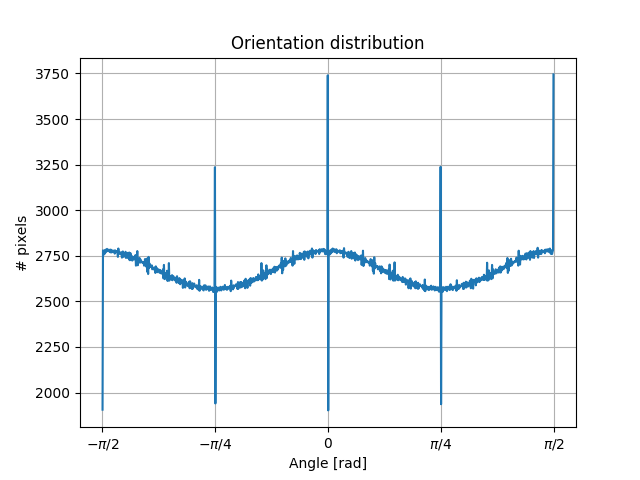

In [53]:
# Get the old orientation
orientation = orientation_features(test_img, sigma=5)[0]  
# Generate the disk-shaped mask to only analize the colors inside the correct radius
mask = np.fromfunction(lambda i, j: np.sqrt((i-orientation.shape[0]//2)**2 + (j-orientation.shape[1]//2)**2), 
                       shape=orientation.shape)    
r = np.min(mask.shape)//2 - np.min(mask.shape)//20
# Generate histograms using the mask
hist, edg = np.histogram(orientation[mask < r], bins = 1000, range = (orientation.min(), orientation.max()))
cent = (edg[0:-1] + edg[1:])/2
# Display the masked orientation
orientation[mask >= r] = -np.pi/2
plt.close('all')
view = viewer([orientation], title=['Orientation of the test image'], cmap='hsv', colorbar=True)
# Display the angle distribution
f = plt.figure(); plt.title('Orientation distribution'); plt.xlabel('Angle [rad]'); plt.ylabel('# pixels')
plt.plot(cent, hist); plt.grid(); 
plt.xticks(ticks=[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2],labels=[r'$-\pi/2$',r'$-\pi/4$',r'$0$',r'$\pi/4$',r'$\pi/2$']); plt.show()

In the first image, you will probably not see any problem since it's very hard to see it by just looking at the orientation image. However, in the distribution plot you can clearly see that some orientations are preferred over others. Specifically, ignoring the very sharp peaks at $0$, $\pm\frac{\pi}{4}$ and $\pm\frac{\pi}{2}$ (an artefact of having a limited number of pixels), there are more pixels with an orientation close to $0$ or $\pm\frac{\pi}{2}$ and less pixels close to $\pm\frac{\pi}{4}$. 

Now why could that be? If we look more closely at the Sobel filter masks $h_x$ and $h_y$

$$h_x = 
\begin{bmatrix} 
    1 & 0 & -1 \\
    2 & 0 & -2 \\ 
    1 & 0 & -1 
\end{bmatrix}
,\;\;\;\;
h_y = 
\begin{bmatrix} 
    1 & 2 & 1 \\
    0 & 0 & 0 \\ 
    -1 & -2 & -1 
\end{bmatrix}
$$

we can see that this filter is not isotropic, meaning it doesn't treat all directions equally. In this case, as we saw in the orientation distribution above, the horizontal and vertical edges are favored, resulting in a biased orientation distribution.

In order to have a non-biased orientation detector, we need to re-implement the `structure_tensor` function using an isotropic gradient filter. There are several to choose from but in this exercise we will calculate the gradient using the Fourier property

$$\frac{\partial f(x,y)}{\partial x} \xrightarrow{\mathcal{F}} j\omega_x\operatorname{F}(\omega_x, \omega_y), \;\;\; 
\frac{\partial f(x,y)}{\partial y} \xrightarrow{\mathcal{F}} j\omega_y\operatorname{F}(\omega_x, \omega_y)\,.$$

As you can see we only need to take the Fourier transform of our image and multiply it with either $j\omega_x$ or $j\omega_y$. Then we can take the inverse Fourier transform and we will have our derivatives in the $x$ and $y$ directions.

**For 1 point**, implement the functions `get_w` and `structure_tensor_improved` in the cells below.

The first step for you is to implement the function `get_w` that simply returns a vector $\omega$ consisting of $m$ equidistant points going from $-\frac{\pi}{2}$ to $\frac{\pi}{2}$.

This is a very simple function that will be used in `structure_tensor_improved` to generate the complex-valued vectors $j\omega_x$ and $j\omega_y$.

<div class="alert alert-info">

**Hint:** Use the function [`np.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html).
</div>

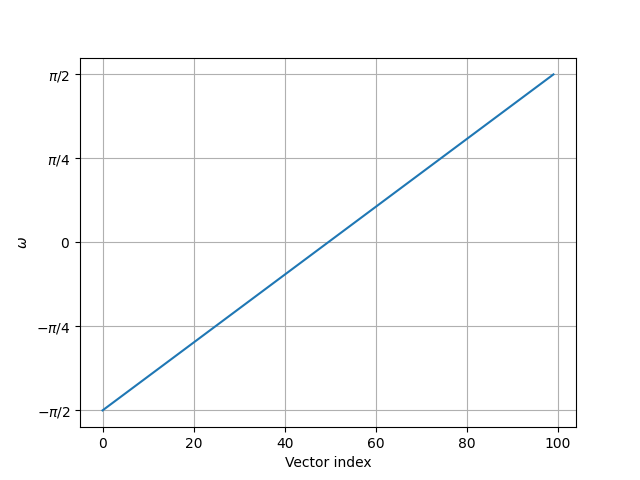

In [40]:
# Calculates omega (w) of length m
def get_w(m):
    w = np.zeros(m)
    
    # YOUR CODE HERE
    w = np.linspace(-np.pi/2,np.pi/2,m)
    return w

# Visualize omega
plt.close('all')
plt.figure("Frequency vector")
plt.plot(get_w(100))
plt.ylabel(r'$\omega$'); plt.xlabel("Vector index"); plt.grid()
plt.yticks(ticks=[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2],labels=[r'$-\pi/2$',r'$-\pi/4$',r'$0$',r'$\pi/4$',r'$\pi/2$']);
plt.show()

Run the next cell for a quick test on $\omega$.

In [41]:
# Perform test on a vector of 10 elements. We will check length, range, and a direct comparison with the solution
w_out = get_w(10)
check = True
if not len(w_out) == 10:
    check = False
    print(f'WARNING!\nThe length of the output vector should be equal to the input parameter m. Expected length=10, your length={len(w_out)}.')
if not np.min(w_out) == -np.pi/2 and np.max(w_out) == np.pi/2:
    check = False
    print(f'WARNING!\nOmega should go from -1.57079633 to 1.57079633 not from {np.min(w_out):.8f} to {np.max(w_out):.8f}!')
if not np.allclose(w_out, [-1.57079633, -1.22173048, -0.87266463, -0.52359878, -0.17453293, 
                           0.17453293,  0.52359878,  0.87266463,  1.22173048,  1.57079633]):
    check = False
    print('WARNING!\nYour omega vector is not yet correct!')
if check:
    print('Well done, the function passed the sanity check.')

Well done, the function passed the sanity check.


In the next cell, complete the function `structure_tensor_improved` by implementing the Fourier domain gradient filters as explained above. The code that generates the arrays $j\omega_x$ and $j\omega_y$ is already provided. It uses your function `get_w` to fill both the rows of the imaginary part of `jw_x` and the columns of the imaginary part of `jw_y` with the vector $\omega$.
<div class="alert alert-info">

**Hint:** You can use the functions `get_FT(img)` to get the complex Fourier transform of `img` and `get_iFT(img_FT)` to get the inverse Fourier transform of `img_FT`. Those functions also take care of performing the correct shifting.
</div>
<div class="alert alert-info">

**Hint:** Implementing these filters might be easier than you think! Or exactly as easy as you thought, but did not know why. Have a look at the NumPy broadcasting rules [here](https://numpy.org/doc/stable/user/basics.broadcasting.html).
</div>

In [43]:
# Function that calculates the elements Jxx, Jxy and Jyy of the structure tensor matrix
def structure_tensor_improved(img, sigma):
    Jxx = None
    Jxy = None
    Jyy = None
    
    # Generate the complex-numbered filters jw_x and jw_y
    jw_x = 1j*get_w(img.shape[1])
    jw_y = 1j*get_w(img.shape[0]).reshape((img.shape[0], 1))
    
    # Gradient calculation using jw_x and jw_y in the Fourier space
    # YOUR CODE HERE
    Fx = get_FT(img) * jw_x # Fourier transform of df/dx
    Fy = get_FT(img) * jw_y # Fourier transform of df/dy
    
    # Calculate fxx, fxy, fyy and then Jxx, Jxy and Jyy from the gradients
    # in exactly the same way as in the original structure tensor function (Part 1)
    # YOUR CODE HERE
    fx = get_iFT(Fx)
    fy = get_iFT(Fy)
    
    Jxx = cv.GaussianBlur(src=fx**2, ksize=(0,0), sigmaX=sigma)
    Jxy = cv.GaussianBlur(src=fx*fy, ksize=(0,0), sigmaX=sigma)
    Jyy = cv.GaussianBlur(src=fy**2, ksize=(0,0), sigmaX=sigma)
    
    return Jxx, Jxy, Jyy

In this part you will need to do the sanity check of the `structure_tensor_improved` function by eye. The cell below will run the function `orientation_features` twice on the `test_img`, once with the old `structure_tensor` and once with the improved version. 

You will be able to see the results in an *IPLabViwer*, where you will see the orientation feature for each version of the `structure_tensor` function, as well as the difference between both results. Once you are sure on the correctness of `structure_tensor_improved`, reflect on the difference and its origins. Moreover, you will see a plot of both orientation distributions. 

The displayed orientation feature is for you to see that you did not mess up the function, and you will most likely not be able to see much difference between the two versions. However, in the orientation distribution plot you should be able to clearly distinguish the Fourier version from the Sobel one. **The Fourier version should be completely flat (with exception of a few sharp spikes)** compared to the Sobel version that looks more like a sinusoidal wave.

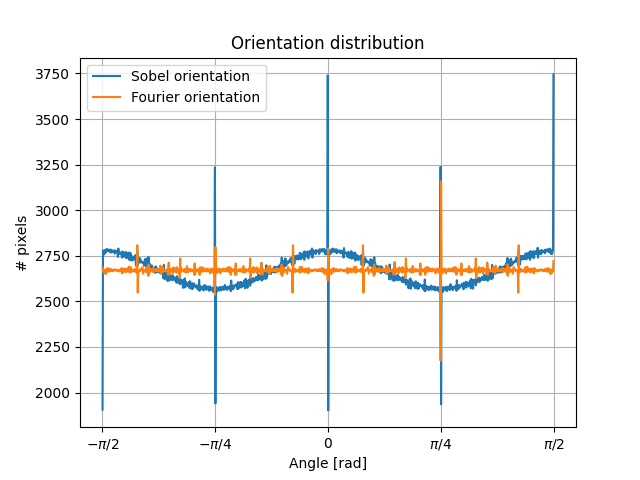

In [44]:
# Get the old orientation
orientation = orientation_features(test_img, sigma=5)[0]
# Replace the structure tensor function by the improved one
old_ST = structure_tensor
structure_tensor = structure_tensor_improved
# Get the improved orientation
try:
    orientation_improved = orientation_features(test_img, sigma=5)[0]
except:
    # Handle errors in the code
    structure_tensor = old_ST
    raise
# Restore the old structure tensor function
structure_tensor = old_ST    

# Generate the disk-shaped mask to only analize the colors inside the correct radius
mask = np.fromfunction(lambda i, j: np.sqrt((i-orientation.shape[0]//2)**2 + (j-orientation.shape[1]//2)**2), 
                       shape=orientation.shape)    
r = np.min(mask.shape)//2-np.min(mask.shape)//20

# Generate histograms using the mask
hist, edg = np.histogram(orientation[mask < r], bins = 1000, range = (orientation.min(), orientation.max()))
hist_improved, edg_improved = np.histogram(orientation_improved[mask < r], bins = 1000, 
                                range = (orientation_improved.min(), orientation_improved.max()))
cent = (edg[0:-1] + edg[1:])/2;
cent_improved = (edg_improved[0:-1] + edg_improved[1:])/2;
# Display the two masked orieantations
orientation[mask >= r] = -np.pi/2
orientation_improved[mask >= r] = -np.pi/2
plt.close('all')
image_list = [orientation, orientation_improved]
title_list = ['Sobel orientation', 'Fourier orientation']
view = viewer(image_list, title=title_list, cmap='hsv', colorbar=True, widgets=True)

# Display the angle distribution
plt.figure()
plt.title('Orientation distribution'); plt.xlabel('Angle [rad]'); plt.ylabel('# pixels')
plt.xticks(ticks=[-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2],labels=[r'$-\pi/2$',r'$-\pi/4$',r'$0$',r'$\pi/4$',r'$\pi/2$']);
plt.plot(cent, hist)
plt.plot(cent_improved, hist_improved)
plt.legend(['Sobel orientation', 'Fourier orientation']); plt.grid(); plt.show()

<div class="alert alert-success">
    <b>Congratulations on finishing the Orientation lab!!</b>
</div>

Make sure to save your notebook (you might want to keep a copy on your personal computer) and upload it to <a href="https://moodle.epfl.ch/course/view.php?id=463">Moodle</a>, **in a zip file with the other notebook of this lab.**

* Keep the name of the notebook as: *2_Orientation.ipynb*,
* Name the `zip` file: *Orientation_lab.zip*.